In [1]:
from ga_regression import *
from matplotlib import pyplot as plt
from functools import partial
import PIL
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from pvutils import iter_subplots
from pyvista import PolyData
import pyvista as pv
from scipy.stats import pearsonr
from ga_population import *
import warnings

C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dg\Documents\python\diffusion-net\experiments\regression_0\ga_regression.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
paths = {
    51: Path(r"D:\resynth\run_51_52\run00051_resynth\2025-09-16-15-34-44\opts_and_metadata.pt"),
    42: Path(r"D:\resynth\run_42_43\run00042_resynth\2025-09-11-16-14-13\opts_and_metadata.pt"),
    48: Path(r"D:\resynth\run_48_49\run00048_resynth\2025-09-12-13-05-14\opts_and_metadata.pt"),
    38: Path(r"D:\resynth\run_38_39\run00038_resynth\2025-09-13-10-59-36\opts_and_metadata.pt"),
    20: Path(r"D:\resynth\run_20_21\run00020_resynth\2025-09-14-15-06-07\opts_and_metadata.pt"),
     9: Path(r"D:\resynth\run_09_10\run00009_resynth\2025-09-15-10-17-13\opts_and_metadata.pt"),
}
readers = {run_id: Readers.from_file(f) for run_id, f in paths.items()}

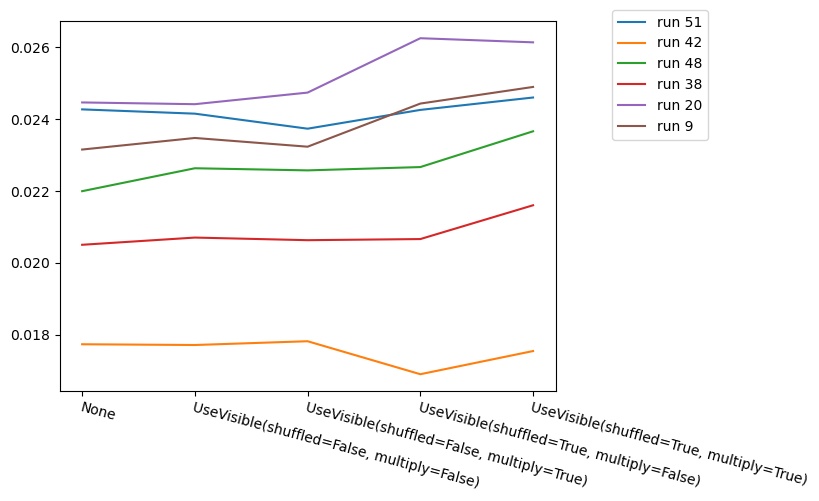

In [3]:
def sorted_data(rs: Readers):
    min_loss = np.array([r.scalar('loss/test')[1].min() for r in rs])
    labels = np.array([str(x) for x in rs.hparams.use_visible])
    i = np.argsort(labels)
    return labels[i], min_loss[i]

for k, v in readers.items():
    labels, losses = sorted_data(v)
    plt.plot(labels, losses, label=f'run {k}')

plt.gca().set_xticks(np.arange(len(labels)), labels, rotation=-15, ha='left', rotation_mode='anchor')
plt.legend(bbox_to_anchor=(1.1, 1.05))

In [4]:
def get_readers(visible_mode: UseVisibleMode | None):
    out = dict()
    tgt = str(visible_mode)
    for run_id, rs in readers.items():
        idx = next(i for i, v in rs.hparams.use_visible.items() if str(v) == tgt)
        out[run_id] = rs[idx]
    return out

# rs = get_readers(UseVisibleMode(False, False))

def get_src_models(visible_mode: UseVisibleMode | None):
    readers = get_readers(visible_mode)
    return {
        run_id: SourceModel.from_reader(reader, cp_data_file=Path(SourceModels.cp_data_files(run_id)))
        for run_id, reader in readers.items()
    }

# _sms = get_src_models(UseVisibleMode(False, False))
_sms = get_src_models(None)
sms = SourceModels(list(_sms.values()))

# TODO: 
- probemeshes don't have visibility
  - need to do this as part of the caching
- sort corpus images by response
- also add the response bars

In [5]:
pms = [p.cached() for p in ProbeMeshSpec.defined()]

In [6]:
recache = False
cp_pm_preds = sms.corpus_probe_mesh_preds(pms=pms, cache_file='cp_pm_preds.hdf', recache=recache)
cp_responses = sms.corpus_observed_responses(cp_pm_preds=cp_pm_preds, cache_file='cpm_responses.hdf', recache=recache)

In [7]:
def _scatter(ax, obs, preds, ttl):
    ax.plot(obs, preds, 'k.')
    ax.plot(obs, preds, 'k.')
    r = pearsonr(obs, preds).statistic
    ax.set_title(f'{ttl} (r={r:.2f})')
    ax.set_xlabel('Observed response')
    ax.set_ylabel('Predicted responses')


def scatter_plots(reader, channel, global_ch_idx, fig=None):
    if fig:
        axs = fig.subplots(1, 3)
    else:
        fig, axs = plt.subplots(1, 3, figsize=(20, 5))
        
    sd = reader.scatter_data
    _scatter(axs[0], *sd.loc(scene_ids=reader.train_scenes, channel=channel), ttl='Train GA')
    _scatter(axs[1], *sd.loc(scene_ids=reader.test_scenes, channel=channel), ttl='Test GA')
    _scatter(axs[2], cp_responses.iloc[:, global_ch_idx], cp_pm_preds.iloc[:, global_ch_idx], ttl='Validate corpus')
    return fig

In [8]:
# vertex weights is a n_stim list of VertexWeights, wehere VertexWeights.weights is (n_vertices, n_channels_total)
# cp_vertex_weights = sms.get_weights(pms, expt_kwargs=dict(outputs_at='vertices'))
# torch.save(cp_vertex_weights, 'cp_vertex_weights.pt')
cp_vertex_weights = torch.load('cp_vertex_weights.pt')

In [9]:
def plot_single_channel_vertex_weights(pms: list[ProbeMesh], vertex_weights: list[VertexWeights], channel_idx: int, img_sz=(5, 5), grid_sz=None, fig=None):
    n_stim = len(pms)
    assert len(vertex_weights) == n_stim
    if grid_sz is None:
        _n = int(np.ceil(np.sqrt(n_stim)))
        grid_sz = (_n, _n)

    nr, nc = grid_sz
    img_sz = np.array(img_sz)

    if fig:
        axs = fig.subplots(nr, nc)
    else:
        fig, axs = plt.subplots(nr, nc, figsize=(img_sz[0] * nc, img_sz[1] * nr), squeeze=False)
        
    axs = axs.reshape(-1)

    for pm, vw, ax in zip(pms, vertex_weights, axs):
        rendered_weights = pm.render(
            weights=vw.weights[:, channel_idx], 
            ground=False, 
            show_scalar_bar=False, 
            window_size=(1024, 1024),
        )
        ax.imshow(rendered_weights)
        ax.axis('off')
    
    for ax in axs[n_stim:]:
        ax.axis('off')
          
    return fig

In [10]:
def load_unit_best(model, channel_idx: int, n_best: int):
    meta = model.reader.metadata
    scenes, responses, weights, fit_fns = meta.load_data(weights=meta.weight_error)
    channel = meta.channel[channel_idx]
    unit_responses = responses.iloc[:, channel_idx].sort_values(ascending=False)
    unit_best_scenes = unit_responses.index[:n_best]

    # Load the meshes
    ga_pms = list(ProbeMesh.load_ga_stim(meta.opts.data_dir, scenes.loc[unit_best_scenes]))

    # Present the meshes to the network to get vertex weights
    dataset = GaDataset(
        df=scenes.loc[unit_best_scenes],  # type: ignore
        responses=responses.loc[unit_best_scenes],  # type: ignore
        root_dir=meta.opts.data_file.parent,
        k_eig=meta.k_eig,
        op_cache_dir=meta.opts.data_dir / 'op_cache',
        file_mode=meta.opts.mesh_file_mode,
        weights=meta.weight_error,
        use_visible=meta.use_visible,
        use_color=meta.use_color,
        norm_verts=meta.norm_verts,
        features=meta.input_features,
        augment=None,
    )
    dataloader = DataLoader(dataset, shuffle=False, batch_size=None)
    expt = model.reader.experiment(outputs_at='vertices')
    assert expt.model.outputs_at == 'vertices'
    _ga_obs, ga_weights = expt.predict(dataloader, agg_fn=lambda x: x)
    ga_weights = [VertexWeights(weights=w) for w in ga_weights]

    return ga_pms, ga_weights

In [18]:
plt.ioff()

n_best = 5
n_cp = len(pms)
cp_grid_nr = int(np.ceil(n_cp / n_best))
cp_grid_sz = (cp_grid_nr, n_best)


for global_ch_idx, (model_idx, model_ch_idx) in enumerate(tqdm(cp_responses.columns, total=cp_responses.shape[1])):
    model = sms[model_idx]
    reader = model.reader
    channel = reader.metadata.channel[model_ch_idx]
    expt_name = reader.trained_file.parts[2]
    ttl =f'{expt_name} - ch{channel}'
    ga_pms, ga_vertex_weights = load_unit_best(model, model_ch_idx, n_best=n_best)

    fig = plt.figure(figsize=(20, 20), constrained_layout=True)
    fig.suptitle(ttl, fontsize=24)
    subfigs = fig.subfigures(3, 1, height_ratios=[2, 1, cp_grid_nr], hspace=.05)
    
    scatter_plots(reader, channel, global_ch_idx, fig=subfigs[0])
    plot_single_channel_vertex_weights(ga_pms, ga_vertex_weights, channel_idx=model_ch_idx, grid_sz=(1, n_best), fig=subfigs[1])
    
    plot_single_channel_vertex_weights(pms, cp_vertex_weights, channel_idx=model_ch_idx, grid_sz=cp_grid_sz, fig=subfigs[2])
    fig.savefig(Path('exported_channels') / (ttl + '.png'))
    plt.close(fig)

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\dg\AppData\Local\Temp\ipykernel_34864\3783494901.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = pearsonr(obs, preds).statistic


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\dg\AppData\Local\Temp\ipykernel_34864\3783494901.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = pearsonr(obs, preds).statistic


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Object `fig.closefig` not found.


In [ ]:
def _pearson_r(x, y):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return pearsonr(preds, responses).statistic
        
## R VALS HIST OVERAL CHANNELS
# unit_rvals = np.zeros(cp_pm_preds.shape[1])
# for i, (unit_idx, r_mesh) in enumerate(cp_pm_preds.items()):
#     r_corpus = cp_responses.loc[:, unit_idx]
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore')
#         unit_rvals[i] = pearsonr(r_mesh, r_corpus).statistic
# unit_rvals[np.isnan(unit_rvals)] = -1

# plt.hist(unit_rvals);
# plt.xlabel('Pearson R')
# plt.ylabel('Number of channels');

In [ ]:

## R VALS HIST OVER STIM
# stim_rvals = np.zeros(cp_pm_preds.shape[0])

# for i, (stim_idx, preds) in enumerate(cp_pm_preds.iterrows()):
#     responses = cp_responses.loc[stim_idx, :]
#     stim_rvals[i] = _pearson_r(preds, responses)

# stim_rvals[np.isnan(stim_rvals)] = -1

# plt.hist(stim_rvals);
# plt.xlabel('Pearson R')
# plt.ylabel('Number of stimuli');